# Load data

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate
from scipy.stats import gaussian_kde

import warnings
from typing import Dict, Any
warnings.filterwarnings('ignore')
print("Import succesfully")

Import succesfully


In [2]:
def load_purchase_history_lazy(base_path='/kaggle/input/recommendation-dataset/'):
    """Load tất cả purchase history chunks bằng LazyFrame"""
    files = [f"{base_path}sales_pers.purchase_history_daily_chunk_{i}.parquet" 
             for i in range(72)]
    
    # Scan tất cả files (lazy loading)
    lf = pl.scan_parquet(files)
    return lf

def load_user_data(base_path='/kaggle/input/recommendation-dataset/'):
    """Load user data chunks"""
    files = [f"{base_path}sales_pers.user_chunk_{i}.parquet" 
             for i in range(10)]
    
    lf = pl.scan_parquet(files)
    return lf

def load_item_chunk():
    files = "/kaggle/input/recommendation-dataset/sales_pers.item_chunk_0.parquet"
    lf = pl.scan_parquet(files)
    return lf

purchase_lf = load_purchase_history_lazy()
user_lf = load_user_data()
item_lf = load_item_chunk()

print("---------- Finish loading data -----------")
print(f"Purchase history lazy chunk size: width = {purchase_lf.width}, length = {purchase_lf.select(pl.len()).collect().item()}")
print(f"User data chunk size: width = {user_lf.width}, length = {user_lf.select(pl.len()).collect().item()}")
print(f"Item chunk size: width = {item_lf.width}, length = {item_lf.select(pl.len()).collect().item()}")

---------- Finish loading data -----------
Purchase history lazy chunk size: width = 16, length = 35729825
User data chunk size: width = 18, length = 4573964
Item chunk size: width = 34, length = 27332


# Preprocess

# User

In [18]:
df_user =user_lf.collect()

In [4]:
df_user.head(5)

customer_id,gender,location,province,membership,timestamp,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,region,location_name,install_app,install_date,district,user_id,is_deleted
i32,str,i32,str,str,i64,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,i64,str,str,bool
14732,"""Nam""",155,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - Grand View Phú Mỹ Hưng""","""In-Store""",1306281600,"""7""","""e1e48206652bf8c279ff0206c69a80…",false
15126,"""Nữ""",300,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 121A Nguyễn Duy Trinh""","""In-Store""",1306281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…",false
29718,"""Nữ""",157,"""Bến Tre""","""Standard""",1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đồng bằng sông Cửu Long""","""BTR - 179 Nguyễn Đình Chiểu""","""In-Store""",1582070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…",false
30077,"""Nữ""",53,"""Hồ Chí Minh""","""Standard""",1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 101 Trần Quang Khải""","""In-Store""",1314230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…",false
30085,"""Nữ""",660,"""Hồ Chí Minh""","""Standard""",1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 85-87 Tây Thạnh""","""In-Store""",1314230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…",false


## Xóa cột không cần thiết

In [19]:
drop_cols = ['is_deleted','sync_error_message','last_sync_date',
             'sync_status_id','district','location','location_name']
df_user = df_user.drop(drop_cols)

df_user.describe().to_pandas()
df_user.head(5)

customer_id,gender,province,membership,timestamp,created_date,updated_date,region,install_app,install_date,user_id
i32,str,str,str,i64,datetime[μs],datetime[μs],str,str,i64,str
14732,"""Nam""","""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1306281600,"""e1e48206652bf8c279ff0206c69a80…"
15126,"""Nữ""","""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1306281600,"""77891759204bd27e69fb11a7b92889…"
29718,"""Nữ""","""Bến Tre""","""Standard""",1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,"""Đồng bằng sông Cửu Long""","""In-Store""",1582070400,"""b8041b584a0bb6655361727a0a6108…"
30077,"""Nữ""","""Hồ Chí Minh""","""Standard""",1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1314230400,"""c52ceaca44a83ec41a219cfaff0e05…"
30085,"""Nữ""","""Hồ Chí Minh""","""Standard""",1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1314230400,"""74ac5764f5d67d341aacf238d7762f…"


## Chúng ta cần chuẩn hóa 126 giá trị trong province về bé hơn hoặc bằng 63 tỉnh thành việt nam

In [20]:
# Chuẩn hoá text: bỏ khoảng trắng, đổi về dạng chuẩn hóa viết hoa đầu


df_user = df_user.with_columns([
    pl.col("province")
      .str.strip_chars()            # xoá khoảng trắng thừa
      .str.to_lowercase()           # về chữ thường
      .str.replace_all("tỉnh ", "") # bỏ từ "tỉnh "
      .str.replace_all("thành phố ", "") # bỏ từ "thành phố "
      .str.to_titlecase()           # viết hoa chữ cái đầu
      .alias("province")
])


In [81]:
len(df_user["province"].unique().sort().to_list()) ## đã chuẩn hóa ok

63

## Tạo thêm các đặc trưng:
- account_age_days: ngày tuổi account từ khi tạo đến ngày update


In [21]:
df_user = df_user.with_columns([
    (pl.col("updated_date") - pl.col("created_date")).dt.total_days().alias("account_age_days"),
])


## Tạo thêm các đặc trưng:
- user_tenure: phân loại tuổi tài khoản , &lt; 365: new , &lt; 1095: Regular, còn lại là Veteran
- region_simplified : Các region miền bắc là North , miền trung là Central , còn lại là các region miền nam
- acquisition_channel: [In-store]: offline, còn lại là online
- loyal_score: thành viên cao cấp có điểm trung thành cao hơn, ngay cả khi cùng số ngày tham gia. Hệ số 1.5 diamond, 1.2 gold , 1 standard
- join_season : Mùa mà user tạo tạo tài khoản

In [29]:
#Tách create_date, update_datethành các thành phần nhỏ hơn để phân tích
df_user = df_user.with_columns([
    pl.col('created_date').dt.year().alias('created_year'),
    pl.col('created_date').dt.month().alias('created_month'),
    pl.col('created_date').dt.day().alias('created_day'),
    
    pl.col('updated_date').dt.year().alias('updated_year'),
    pl.col('updated_date').dt.month().alias('updated_month'),
    pl.col('updated_date').dt.day().alias('updated_day'),
])
df_user = df_user.drop(['created_date', 'updated_date'])

In [30]:
    # Tạo thêm các đặc trưng cho bài toán recommend items
    df_user = df_user.with_columns([
        
        # Phân loại theo độ tuổi tài khoản
        pl.when(pl.col('account_age_days') < 365).then(pl.lit('New'))
        .when(pl.col('account_age_days') < 1095).then(pl.lit('Regular'))
        .otherwise(pl.lit('Veteran')).alias('user_tenure'),
        
        # Phân loại theo miền
        pl.when(pl.col('region').is_in(['Trung du và miền núi phía Bắc', 'Duyên hải Bắc Bộ', 'Đồng bằng sông Hồng']))
       .then(pl.lit('North'))
       .when(pl.col('region').is_in(['Bắc Trung Bộ', 'Duyên hải Nam Trung Bộ', 'Tây Nguyên']))
       .then(pl.lit('Central'))
       .otherwise(pl.lit('South')).alias('region_simplified'),
        
        # Phân loại theo cách cài app
        pl.when(pl.col('install_app') == 'In-Store').then(pl.lit('Offline'))
        .otherwise(pl.lit('Online')).alias('acquisition_channel'),
        
        
        # Tạo loyalty score dựa trên tuổi tài khoản và membership
        pl.when(pl.col('membership') == 'Diamond').then(pl.col('account_age_days') * 1.5)
        .when(pl.col('membership') == 'Gold').then(pl.col('account_age_days') * 1.2)
        .otherwise(pl.col('account_age_days')).alias('loyalty_score')
    ])
    
    # Add seasonal joining pattern in a separate step after created_month is created
    df_user = df_user.with_columns([
        pl.when(pl.col('created_month').is_in([12, 1, 2])).then(pl.lit('Winter'))
        .when(pl.col('created_month').is_in([3, 4, 5])).then(pl.lit('Spring'))
        .when(pl.col('created_month').is_in([6, 7, 8])).then(pl.lit('Summer'))
        .otherwise(pl.lit('Fall')).alias('join_season')
    ])

In [31]:
df_user.head(5)

customer_id,gender,province,membership,timestamp,region,install_app,install_date,user_id,account_age_days,created_year,created_month,created_day,updated_year,updated_month,updated_day,user_tenure,region_simplified,acquisition_channel,loyalty_score,join_season
i32,str,str,str,i64,str,str,i64,str,i64,i32,i8,i8,i32,i8,i8,str,str,str,f64,str
14732,"""Nam""","""Hồ Chí Minh""","""Standard""",1306357911,"""Đông Nam Bộ""","""In-Store""",1306281600,"""e1e48206652bf8c279ff0206c69a80…",5156,2011,5,25,2025,7,7,"""Veteran""","""South""","""Offline""",5156.0,"""Spring"""
15126,"""Nữ""","""Hồ Chí Minh""","""Standard""",1306357911,"""Đông Nam Bộ""","""In-Store""",1306281600,"""77891759204bd27e69fb11a7b92889…",5156,2011,5,25,2025,7,7,"""Veteran""","""South""","""Offline""",5156.0,"""Spring"""
29718,"""Nữ""","""Bến Tre""","""Standard""",1312126692,"""Đồng bằng sông Cửu Long""","""In-Store""",1582070400,"""b8041b584a0bb6655361727a0a6108…",5089,2011,7,31,2025,7,7,"""Veteran""","""South""","""Offline""",5089.0,"""Summer"""
30077,"""Nữ""","""Hồ Chí Minh""","""Standard""",1314302782,"""Đông Nam Bộ""","""In-Store""",1314230400,"""c52ceaca44a83ec41a219cfaff0e05…",5064,2011,8,25,2025,7,7,"""Veteran""","""South""","""Offline""",5064.0,"""Summer"""
30085,"""Nữ""","""Hồ Chí Minh""","""Standard""",1314310024,"""Đông Nam Bộ""","""In-Store""",1314230400,"""74ac5764f5d67d341aacf238d7762f…",5064,2011,8,25,2025,7,7,"""Veteran""","""South""","""Offline""",5064.0,"""Summer"""


In [54]:
df_user.shape

(4573964, 21)

In [32]:
# Cơ bản
df_user.write_parquet('user_data.parquet')

## Encode

In [86]:
'''
##Encode các biến phân loại
# Label encoding cho biến nominal using Polars map_elements
nominal_cols = ['gender', 'province', 'region', 'region_simplified', 'acquisition_channel', 'install_app']

for col in nominal_cols:
    # Get unique values and create mapping
    unique_values = df_user[col].unique().sort().to_list()
    # Create mapping dictionary
    mapping_dict = {val: idx for idx, val in enumerate(unique_values)}
    
    # Apply mapping using Polars map_elements
    df_user = df_user.with_columns([
        pl.col(col).map_elements(lambda x: mapping_dict.get(x, -1), return_dtype=pl.Int32).alias(f"{col}_encoded")
    ])

# ordinal encoding cho biến ordinal
# standard < gold < diamond
membership_order = {'Standard': 1, 'Gold': 2, 'Diamond': 3}
df_user = df_user.with_columns([
    pl.col('membership').map_elements(lambda x: membership_order.get(x, 0), return_dtype=pl.Int32).alias('membership_encoded')
])

# season order winter < spring < summer < fall
season_order = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
df_user = df_user.with_columns([
    pl.col('join_season').map_elements(lambda x: season_order.get(x, 0), return_dtype=pl.Int32).alias('join_season_encoded')
])

# User tenure encoding: New < Regular < Veteran
tenure_order = {'New': 1, 'Regular': 2, 'Veteran': 3}
df_user = df_user.with_columns([
    pl.col('user_tenure').map_elements(lambda x: tenure_order.get(x, 0), return_dtype=pl.Int32).alias('user_tenure_encoded')
])
'''

In [87]:
'''
# Danh sách các cột gốc đã được encode
cols_to_drop = nominal_cols + ['membership', 'join_season', 'user_tenure']

# Drop cột
df_user = df_user.drop(cols_to_drop)
df_user.head(5)
'''

customer_id,install_date,user_id,account_age_days,created_year,created_month,created_day,created_hour,updated_year,updated_month,updated_day,updated_hour,loyalty_score,gender_encoded,province_encoded,region_encoded,region_simplified_encoded,acquisition_channel_encoded,install_app_encoded,membership_encoded,join_season_encoded,user_tenure_encoded
i32,i64,str,i64,i32,i8,i8,i8,i32,i8,i8,i8,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32
14732,1306281600,"""e1e48206652bf8c279ff0206c69a80…",5156,2011,5,25,21,2025,7,7,15,5156.0,1,24,5,2,0,4,1,2,3
15126,1306281600,"""77891759204bd27e69fb11a7b92889…",5156,2011,5,25,21,2025,7,7,15,5156.0,2,24,5,2,0,4,1,2,3
29718,1582070400,"""b8041b584a0bb6655361727a0a6108…",5089,2011,7,31,15,2025,7,7,15,5089.0,2,10,7,2,0,4,1,3,3
30077,1314230400,"""c52ceaca44a83ec41a219cfaff0e05…",5064,2011,8,25,20,2025,7,7,15,5064.0,2,24,5,2,0,4,1,3,3
30085,1314230400,"""74ac5764f5d67d341aacf238d7762f…",5064,2011,8,25,22,2025,7,7,15,5064.0,2,24,5,2,0,4,1,3,3


# ITEM

In [39]:
item_df = item_lf.collect()
print("Kích thước dữ liệu:", item_df.shape)
print("Các cột:", item_df.columns)

Kích thước dữ liệu: (27332, 34)
Các cột: ['p_id', 'item_id', 'price', 'category_l1_id', 'category_l1', 'category_l2_id', 'category_l2', 'category_l3_id', 'category_l3', 'category_id', 'category', 'description', 'brand', 'manufacturer', 'creation_timestamp', 'is_deleted', 'created_date', 'updated_date', 'sync_status_id', 'last_sync_date', 'sync_error_message', 'image_url', 'gender_target', 'age_group', 'item_type', 'gp', 'weight', 'color', 'size', 'origin', 'volume', 'material', 'sale_status', 'description_new']


In [36]:
item_df.head(5)

p_id,item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,manufacturer,creation_timestamp,is_deleted,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,image_url,gender_target,age_group,item_type,gp,weight,color,size,origin,volume,material,sale_status,description_new
i32,str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,str,str,i64,bool,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,str,"decimal[38,4]",f32,str,str,str,str,str,i32,str
17065,"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""","""Dr.Brown's""","""Không xác định""",1333531544,false,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
72370,"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""","""Con Cưng""","""Không xác định""",1503046250,false,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,null,null,null,"""Không xác định""","""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Không xác định"""
31154,"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…","""Thương hiệu khác""","""Không xác định""",1358501584,false,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
46123,"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…","""Merries Nhật""","""Không xác định""",1400062039,false,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""
46127,"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …","""Merries Nhật""","""Không xác định""",1400062040,false,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""


In [35]:
item_df["sale_status"].value_counts(normalize=True)

sale_status,proportion
i32,f64
0,0.832797
1,0.167203


In [36]:
item_df.select([c for c in item_df.columns if "timestamp" in c or "date" in c]).head()

creation_timestamp,created_date,updated_date,last_sync_date
i64,datetime[μs],datetime[μs],datetime[μs]
1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,2025-07-18 17:59:29.898256
1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,null
1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,2025-07-18 17:59:29.898256
1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,2025-07-18 17:59:29.898256
1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,2025-07-18 17:59:29.898256


In [40]:
# === 1. Drop cột không cần thiết ===
drop_cols = [
    "p_id", "manufacturer", "description", "sync_error_message", "image_url",
    "color", "size", "weight", "origin", "volume", "material",
    "description_new", "is_deleted", "sync_status_id", "last_sync_date"
]
item_df = item_df.drop([c for c in drop_cols if c in item_df.columns])
'''
# === 2. Drop các cột category dạng text (vì đã có *_id tương ứng) ===
category_text_cols = ["category_l1", "category_l2", "category_l3", "category"]
item_df = item_df.drop([c for c in category_text_cols if c in item_df.columns])
'''
'''
# === 3. Encode các cột phân loại (categorical) ===
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["brand", "gender_target", "age_group", "item_type"]
for col in categorical_cols:
    if col in item_df.columns:
        le = LabelEncoder()
        item_df = item_df.with_columns(
            pl.Series(col, le.fit_transform(item_df[col].to_pandas())))
'''
# === 4. Xử lý dữ liệu thời gian ===
# Lấy đúng cột gốc, không lấy cột sinh ra từ trước
time_cols = [
    c for c in item_df.columns
    if (("timestamp" in c) or ("date" in c))
    and not any(s in c for s in ["_year", "_month", "_day"])
]

# Tạo bản sao danh sách để không bị mở rộng trong vòng lặp
for col in time_cols.copy():
    if item_df[col].dtype != pl.Datetime:
        try:
            item_df = item_df.with_columns(
                pl.col(col).cast(pl.Utf8).str.strptime(pl.Datetime, strict=False)
            )
        except Exception as e:
            print(f"Bỏ qua cột {col}: không thể chuyển sang datetime ({e}).")
            continue

    # tách đặc trưng năm/tháng/ngày
    item_df = item_df.with_columns([
        pl.col(col).dt.year().alias(f"{col}_year"),
        pl.col(col).dt.month().alias(f"{col}_month"),
        pl.col(col).dt.day().alias(f"{col}_day")
    ])
    # drop cột gốc
    item_df = item_df.drop(col)


# === 5. Xử lý outlier và phân phối lệch cho cột price, gp ===
for col in ["price", "gp"]:
    if col in item_df.columns:
        item_df = item_df.with_columns(
            (pl.col(col) + 1).log().alias(f"{col}_log")
        )

# === 7. Kiểm tra kết quả ===
item_df.head(5)
print(item_df.columns)
print("Shape sau khi xử lý:", item_df.shape)

Bỏ qua cột creation_timestamp: không thể chuyển sang datetime (could not find an appropriate format to parse dates, please define a format).
['item_id', 'price', 'category_l1_id', 'category_l1', 'category_l2_id', 'category_l2', 'category_l3_id', 'category_l3', 'category_id', 'category', 'brand', 'creation_timestamp', 'gender_target', 'age_group', 'item_type', 'gp', 'sale_status', 'created_date_year', 'created_date_month', 'created_date_day', 'updated_date_year', 'updated_date_month', 'updated_date_day', 'price_log', 'gp_log']
Shape sau khi xử lý: (27332, 25)


In [41]:
item_df.head(5)

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,brand,creation_timestamp,gender_target,age_group,item_type,gp,sale_status,created_date_year,created_date_month,created_date_day,updated_date_year,updated_date_month,updated_date_day,price_log,gp_log
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,i64,str,str,str,"decimal[38,4]",i32,i32,i8,i8,i32,i8,i8,f64,f64
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Dr.Brown's""",1333531544,"""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,0,2012,4,4,2025,8,18,11.502885,10.514041
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Con Cưng""",1503046250,"""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,0,2017,8,18,2025,9,18,11.141876,0.0
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""Thương hiệu khác""",1358501584,"""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,0,2013,1,18,2025,9,27,10.71444,9.581283
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""Merries Nhật""",1400062039,"""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,0,2014,5,14,2025,9,27,12.901719,10.997924
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""Merries Nhật""",1400062040,"""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,0,2014,5,14,2025,9,27,12.901719,11.093843


In [41]:
'''import polars as pl
from sklearn.preprocessing import LabelEncoder

# --- 1️⃣ Chuẩn hóa brand ---
if "brand" in item_df.columns:
    item_df = item_df.with_columns(
        pl.col("brand")
        .cast(pl.Utf8)
        .str.strip_chars()
        .str.to_uppercase()
        .fill_null("OTHER_UNKNOWN")
        .alias("brand")
    )

    # --- 2️⃣ Gom nhóm thương hiệu hiếm ---
    min_freq = 10
    brand_counts = (
        item_df["brand"].value_counts()
        .to_pandas()
        .set_index("brand")["count"]
    )

    rare_brands = set(brand_counts[brand_counts < min_freq].index)

    # ❗ Dùng pl.lit() để gán giá trị literal
    item_df = item_df.with_columns(
        pl.when(pl.col("brand").is_in(list(rare_brands)))
        .then(pl.lit("RARE_BRAND"))
        .otherwise(pl.col("brand"))
        .alias("brand")
    )

    # --- 3️⃣ Encode ---
    le = LabelEncoder()
    item_df = item_df.with_columns(
        pl.Series("brand", le.fit_transform(item_df["brand"].to_pandas()))
    )

print("✅ Hoàn tất xử lý cột brand")
print(item_df.select("brand").head(10))'''

✅ Hoàn tất xử lý cột brand
shape: (10, 1)
┌───────┐
│ brand │
│ ---   │
│ i64   │
╞═══════╡
│ 30    │
│ 19    │
│ 157   │
│ 89    │
│ 89    │
│ 8     │
│ 134   │
│ 58    │
│ 67    │
│ 173   │
└───────┘


In [42]:
item_df

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,brand,creation_timestamp,gender_target,age_group,item_type,gp,sale_status,created_date_year,created_date_month,created_date_day,updated_date_year,updated_date_month,updated_date_day,price_log,gp_log
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,i64,str,str,str,"decimal[38,4]",i32,i32,i8,i8,i32,i8,i8,f64,f64
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Dr.Brown's""",1333531544,"""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,0,2012,4,4,2025,8,18,11.502885,10.514041
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Con Cưng""",1503046250,"""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,0,2017,8,18,2025,9,18,11.141876,0.0
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""Thương hiệu khác""",1358501584,"""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,0,2013,1,18,2025,9,27,10.71444,9.581283
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""Merries Nhật""",1400062039,"""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,0,2014,5,14,2025,9,27,12.901719,10.997924
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""Merries Nhật""",1400062040,"""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,0,2014,5,14,2025,9,27,12.901719,11.093843
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""3389000000238""",129000.0000,3292,"""Thời trang""",6021,"""Thời trang bé gái""",4563,"""Đầm bé gái""",3389,"""Đầm bé gái Animo Easy""","""Animo""",1740043302,"""Không xác định""","""Không xác định""","""Không xác định""",54386.4000,1,2025,2,20,2025,9,25,11.767575,10.903888
"""3389000000212""",129000.0000,3292,"""Thời trang""",6021,"""Thời trang bé gái""",4563,"""Đầm bé gái""",3389,"""Đầm bé gái Animo Easy""","""Animo""",1740043302,"""Không xác định""","""Không xác định""","""Không xác định""",54386.4000,1,2025,2,20,2025,9,25,11.767575,10.903888
"""3389000000213""",129000.0000,3292,"""Thời trang""",6021,"""Thời trang bé gái""",4563,"""Đầm bé gái""",3389,"""Đầm bé gái Animo Easy""","""Animo""",1740043302,"""Không xác định""","""Không xác định""","""Không xác định""",54386.4000,1,2025,2,20,2025,9,26,11.767575,10.903888


In [43]:
item_df.write_parquet("item_data.parquet")

# PURCHASE

In [44]:
purchase_df = purchase_lf.collect()
purchase_df.head()

timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,location,discount,is_deleted
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,i32,"decimal[38,4]",bool
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""","""Purchase""",1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,2024-12-24 18:20:09.453,"""In-Store""","""VietQR""",656,0.0000,false
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""","""Purchase""",1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,2024-12-24 19:28:01.870,"""In-Store""","""Tiền mặt""",143,0.0000,false
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""","""Purchase""",2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,2024-12-24 19:50:43.760,"""In-Store""","""MoMo""",213,0.0000,false
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""","""Purchase""",2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,2024-12-24 19:49:39.223,"""In-Store""","""MoMo""",213,13000.0000,false
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""","""Purchase""",1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,2024-12-28 10:28:49.413,"""Android""","""MoMo""",590,10000.0000,false


In [47]:
purchase_df = purchase_df.drop(["event_type", "is_deleted"])

In [60]:
'''
from sklearn.preprocessing import LabelEncoder

cat_cols = ["channel", "payment"]

for col in cat_cols:
    le = LabelEncoder()
    purchase_df = purchase_df.with_columns(
        pl.Series(
            name=f"{col}_enc",
            values=le.fit_transform(purchase_df[col].to_pandas().astype(str))
        )
    )
'''
# k cần encode

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

cols = [
    "timestamp", "channel_enc", "payment_enc",
    "price", "quantity", "discount",
]

df_sample = purchase_df.select(cols).sample(n=100_000, seed=42).to_pandas()
corr_matrix = df_sample.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Heatmap – Tương quan giữa các đặc trưng numeric (100K mẫu)", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
#purchase_df = purchase_df.drop(["channel", "payment"])

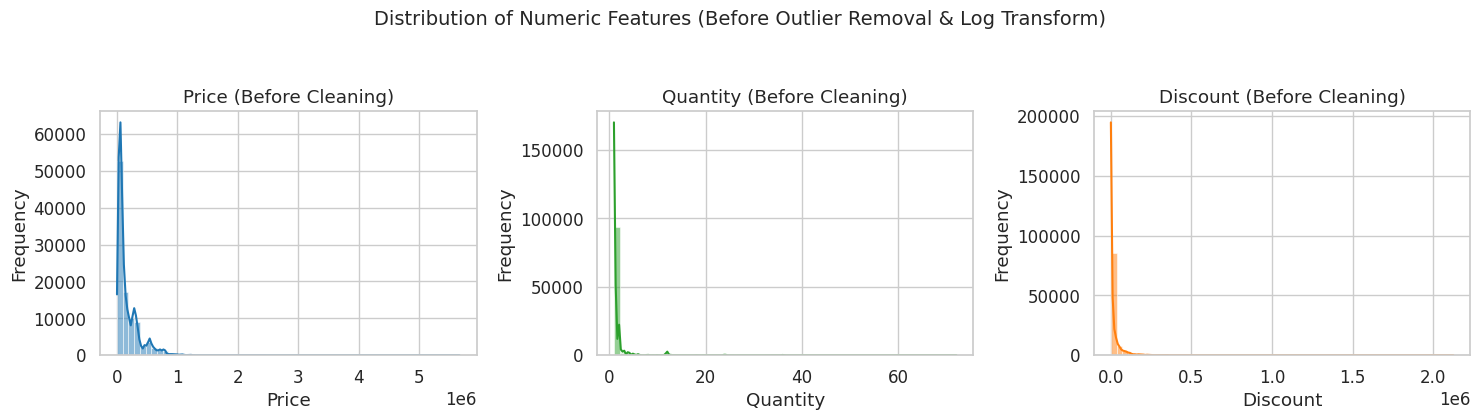

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = (
    purchase_df
    .select(["price", "quantity", "discount"])
    .sample(n=100_000, seed=42)  
    .to_pandas()
)

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

sns.histplot(df_raw["price"], bins=60, kde=True, color="#1f77b4", ax=axes[0])
axes[0].set_title("Price (Before Cleaning)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

sns.histplot(df_raw["quantity"], bins=60, kde=True, color="#2ca02c", ax=axes[1])
axes[1].set_title("Quantity (Before Cleaning)")
axes[1].set_xlabel("Quantity")
axes[1].set_ylabel("Frequency")

sns.histplot(df_raw["discount"], bins=60, kde=True, color="#ff7f0e", ax=axes[2])
axes[2].set_title("Discount (Before Cleaning)")
axes[2].set_xlabel("Discount")
axes[2].set_ylabel("Frequency")

plt.suptitle("Distribution of Numeric Features (Before Outlier Removal & Log Transform)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [64]:
'''purchase_df = purchase_df.with_columns(
    (pl.col("price") * pl.col("quantity") * (1 - pl.col("discount"))).alias("total_value")
) ''' #không dùng được

In [50]:
purchase_df["discount"].unique()

discount
"decimal[38,4]"
0.0000
0.0183
0.0224
0.0366
0.0418
…
4865000.0000
4956000.0000
5366499.9990


In [65]:
''' # chỉ chạy cell khi eda
import polars as pl
import numpy as np

num_cols = ["price", "quantity", "discount"]

def remove_outliers_iqr(df: pl.DataFrame, col: str, k: float = 1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return df.filter((pl.col(col) >= lower) & (pl.col(col) <= upper))

for c in num_cols:
    purchase_df = remove_outliers_iqr(purchase_df, c)

for c in num_cols:
    purchase_df = purchase_df.with_columns(
        (pl.col(c) + 1).log().alias(f"{c}_log")
    )
'''

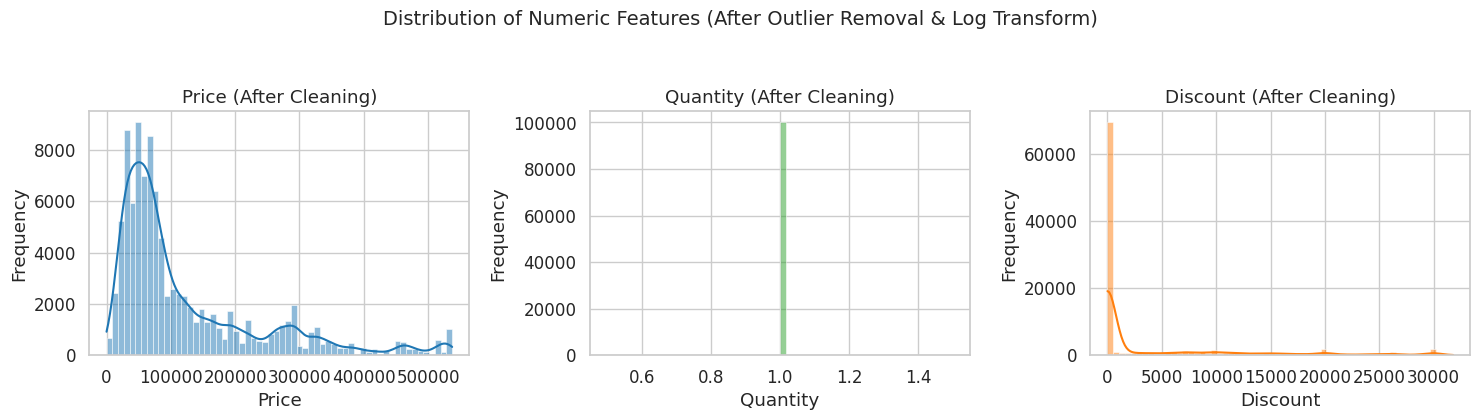

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = (
    purchase_df
    .select(["price", "quantity", "discount"])
    .sample(n=100_000, seed=42)  
    .to_pandas()
)

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

sns.histplot(df_raw["price"], bins=60, kde=True, color="#1f77b4", ax=axes[0])
axes[0].set_title("Price (After Cleaning)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

sns.histplot(df_raw["quantity"], bins=60, kde=True, color="#2ca02c", ax=axes[1])
axes[1].set_title("Quantity (After Cleaning)")
axes[1].set_xlabel("Quantity")
axes[1].set_ylabel("Frequency")

sns.histplot(df_raw["discount"], bins=60, kde=True, color="#ff7f0e", ax=axes[2])
axes[2].set_title("Discount (After Cleaning)")
axes[2].set_xlabel("Discount")
axes[2].set_ylabel("Frequency")

plt.suptitle("Distribution of Numeric Features (After Outlier Removal & Log Transform)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [51]:
import polars as pl

purchase_df = purchase_df.with_columns(
    pl.col("created_date").cast(pl.Datetime).alias("created_date")
)

purchase_df = purchase_df.with_columns([
    pl.col("created_date").dt.year().alias("created_year"),
    pl.col("created_date").dt.month().alias("created_month"),
    pl.col("created_date").dt.day().alias("created_day"),
    pl.col("created_date").dt.weekday().alias("created_weekday")  
])

purchase_df = purchase_df.with_columns(
    pl.when(pl.col("created_month").is_in([3, 4, 5]))
      .then(pl.lit("Spring"))
    .when(pl.col("created_month").is_in([6, 7, 8]))
      .then(pl.lit("Summer"))
    .when(pl.col("created_month").is_in([9, 10, 11]))
      .then(pl.lit("Autumn"))
    .otherwise(pl.lit("Winter"))
    .alias("season_purchase")
)

purchase_df = purchase_df.drop(["created_date", "updated_date"])

In [68]:
purchase_df = purchase_df.drop(["price", "quantity", "discount"])

In [52]:
purchase_df

timestamp,user_id,item_id,event_value,price,date_key,quantity,customer_id,channel,payment,location,discount,created_year,created_month,created_day,created_weekday,season_purchase
i64,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,str,str,i32,"decimal[38,4]",i32,i8,i8,i8,str
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""",1.0000,49000.0000,20241224,1,5254214,"""In-Store""","""VietQR""",656,0.0000,2024,12,24,2,"""Winter"""
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""",1.0000,69000.0000,20241224,1,7573232,"""In-Store""","""Tiền mặt""",143,0.0000,2024,12,24,2,"""Winter"""
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""",2.0000,75000.0000,20241224,2,8187418,"""In-Store""","""MoMo""",213,0.0000,2024,12,24,2,"""Winter"""
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""",2.0000,58500.0000,20241224,2,8187418,"""In-Store""","""MoMo""",213,13000.0000,2024,12,24,2,"""Winter"""
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""",1.0000,89000.0000,20241228,1,6931560,"""Android""","""MoMo""",590,10000.0000,2024,12,28,6,"""Winter"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1704800576,"""5f98a0300ab202bab25aa4466d6486…","""2679000910001""",1.0000,345000.0000,20240109,1,3954948,"""In-Store""","""Cà thẻ""",646,0.0000,2024,1,9,2,"""Winter"""
1704827287,"""ca6dd0d427f147b78ab768e0067e23…","""1318000000003""",1.0000,54000.0000,20240109,1,6248692,"""In-Store""","""Tiền mặt""",88,0.0000,2024,1,9,2,"""Winter"""
1704828403,"""4f9fd64175363798c8023c706653f7…","""2363000000001""",1.0000,299000.0000,20240109,1,5795950,"""In-Store""","""Tiền mặt""",666,0.0000,2024,1,9,2,"""Winter"""


In [53]:
purchase_df.write_parquet("purchase_data.parquet")

# MERGE

In [ ]:

import polars as pl

merged_df = purchase_df.join(df_user, on="user_id", how="left")
merged_df = merged_df.join(item_df, on="item_id", how="left")

output_path = "/kaggle/working/merged_dataset.parquet"
merged_df.write_parquet(output_path)


In [ ]:
item_pop = (
    merged_df
    .group_by("item_id")
    .agg(pl.count("user_id").alias("item_popularity"))
)
merged_df = merged_df.join(item_pop, on="item_id", how="left")
user_item_freq = (
    merged_df
    .group_by(["user_id", "item_id"])
    .agg(pl.count().alias("user_item_freq"))
)
merged_df = merged_df.join(user_item_freq, on=["user_id", "item_id"], how="left")

In [ ]:
merged_df

**Task 1: Loại bỏ các cột mà nhóm nghĩ là không cần thiết.**

* Bảng user: Xóa các cột is_deleted, sync_error_message, last_sync_date, sync_status_id
* Bảng item: Xóa các cột p_id, manufacturer, description, sync_error_message, image_url, color, size, weight, origin, volume, material, description_new, is_deleted, sync_status_id, last_sync_date.
* Bảng purchase history: Xóa các cột event_type, event_value, is_deleted.

**Task 2: Xử lý NULL, Xử lý Outlier**
* Bảng item: Xử lý outlier cho cột price và gp bằng IQR
* Bảng purchase history: Xử lý outlier cho cột price, quantity, discount bằng IQR

**Task 3: Phân tích tương đồng và xác định xem các thuộc tính tương tự nhau. Từ đó loại bỏ đặc trưng thừa.**

Sử dụng heatmap để phân tích độ tương đồng giữa các đặc trưng. Trong bảng user, ba đặc trưng district, location, location_name có độ tương đồng cao với region (0.95) vì thế loại bỏ ba đặc trưng này. Tương tự trong bảng item, gp có độ tương đồng cao với price (0.89) nên loại bỏ cột gp

**Task 4: Chuẩn hóa dữ liệu (nếu có), biến đổi dữ liệu**

* Bảng user: Chuẩn hóa cột province
* Bảng item: Label encode các cột gender, province, region, region_simplified, acquisition_channel, install_app. Dùng log transform để chuẩn hóa cột price sau khi loại bỏ outlier.
* Bảng purchase history: Label encode với cột channel và payment. Dùng log transform để chuẩn hóa price, quantity, discount sau khi loại bỏ outlier.

**Task 5: Nhóm hãy suy nghĩ xem, với bài toán dự đoán mua hàng, ta có thể tạo mới những đặc trưng nào. Sau đó tiến hành rút trích thêm các đặc trưng. Task này rất quan trọng vì ảnh hưởng hiệu quả của hệ thống.**

* Bảng user: Tạo đặc trưng mới là account_age_days, user_tenure, region_simplified, acquisition_channel, loyal_score, join_season
* Bảng purchase history: Tạo đặc trưng mới là user_item_freq, total_value, item_popularity.
Ngoài ra, các bảng item và purchase history có các cột kiểu datetime thì dựa vào giá trị cột
và tạo thêm đặc trưng mới như ngày, tháng, năm, thứ trong tuần, giờ

| Feature | Thuộc bảng | Ý nghĩa | Ghi chú |
|----------|-------------|----------|----------|
| **account_age_days** | user | Số ngày kể từ khi người dùng tạo tài khoản | `current_date - account_created_date` |
| **user_tenure** | user | Thời gian hoạt động của người dùng | Có thể tính theo tháng hoặc năm |
| **region_simplified** | user | Vùng địa lý rút gọn (miền Bắc / Trung / Nam, hoặc tỉnh/thành) | Chuẩn hóa từ cột `location` hoặc `address` |
| **acquisition_channel** | user | Kênh người dùng đăng ký (social, organic, ads...) | Giúp phân tích hành vi theo kênh thu hút |
| **loyal_score** | user | Điểm trung thành của người dùng | Có thể dựa trên tần suất mua và tổng chi tiêu |
| **join_season** | user | Mùa trong năm khi người dùng đăng ký | `Spring / Summer / Autumn / Winter` từ tháng tạo tài khoản |
| **user_item_freq** | purchase_history | Số lần user đã mua / tương tác với item đó | Đo mức độ quan tâm |
| **total_value** | purchase_history | Tổng chi tiêu thực tế | `price * quantity * (1 - discount)` |
| **item_popularity** | purchase_history / item | Số lượng user đã mua sản phẩm | Độ “hot” của item |
| **discount_rate** | purchase_history | Tỷ lệ giảm giá trung bình | Phản ánh hành vi “săn sale” |
| **recency** | purchase_history | Số ngày kể từ lần mua gần nhất đến hiện tại | Dự báo khả năng mua lại |
| **created_year** | purchase_history | Năm diễn ra giao dịch | Từ `created_date` |
| **created_month** | purchase_history | Tháng diễn ra giao dịch | Từ `created_date` |
| **created_day** | purchase_history | Ngày trong tháng | Từ `created_date` |
| **created_hour** | purchase_history | Giờ trong ngày | Hỗ trợ nhận diện khung giờ mua sắm |
| **created_weekday** | purchase_history | Thứ trong tuần | Xác định thói quen mua hàng theo ngày |

